# Create a logistic regression model to predict gene mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 500
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

Wall time: 1min 54s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

Wall time: 1min 8s


In [6]:
# GENES

genes_LungCancer = {
    '207': 'AKT1', 
    '238': 'ALK',  
    '673': 'BRAF', 
    '4921':'DDR2',
    '1956':'EGFR',
    '2064':'ERBB2',
    '3845':'KRAS',
    '5604':'MAP2K1',
    '4893':'NRAS',
    '5290':'PIK3CA',
    '5728':'PTEN',
    '5979':'RET',
    '6016':'RIT1',
    '6098':'ROS1',
}

genes_TumorSuppressors = {
    '324': 'APC',  
    '672': 'BRCA1',  
    '675': 'BRCA2',
    '1029':'CDKN2A',
    '1630':'DCC',
    '4089':'SMAD4',
    '4087':'SMAD2',
    '4221':'MEN1',
    '4763':'NF1',
    '4771':'NF2',
    '7157':'TP53', 
    '5728':'PTEN', 
    '5925':'RB1',
    '7428':'VHL',
    '7486':'WRN',
    '7490':'WT1',
}

genes_Oncogenes = {
    '5155':'PDGFB', #growth factor
    '5159':'PDGFRB', #growth factor 
    '3791':'KDR', #receptor tyrosine kinases
    '25':'ABL1', #Cytoplasmic tyrosine kinases
    '6714':'SRC', #Cytoplasmic tyrosine kinases
    '5894':'RAF1',#cytoplasmic serine kinases
    '3265':'HRAS',#regulatory GTPases
    '4609':'MYC',#Transcription factors
    '2353':'FOS',#Transcription factors
    
}

list_of_genes = list(genes_LungCancer.keys()) + list(genes_TumorSuppressors.keys()) + list(genes_Oncogenes.keys())

gene_symbols = list(genes_LungCancer.values()) + list(genes_TumorSuppressors.values()) + list(genes_Oncogenes.values())

AUROCS_train = []
AUROCS_test = []
p = []

In [7]:
#function

def fs_mad(x, y):
    """
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))


In [8]:
for GENE in list_of_genes:
    
    y = Y[GENE]
    # The percentage of tumors
    per = y.value_counts(True)
    # Set aside 10% of the data for testing, this can only be done where the number of mutations is large enough
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

    # select the top features with the highest MAD
    feature_select = SelectKBest(fs_mad, k=n_feature_kept)
    # Include loss='log' in param_grid doesn't work with pipeline somehow
    clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

    # joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
    # Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
    warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
    clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
    pipeline = make_pipeline(
        feature_select,  # Feature selection
        StandardScaler(),  # Feature scaling
        clf_grid)
    # Fit the model (the computationally intensive part)
    pipeline.fit(X=X_train, y=y_train)
    best_clf = clf_grid.best_estimator_
    feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
   
    # Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
    warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array') 
    AUROCS_train.append(roc_auc_score(y_train, y_pred_train))
    AUROCS_test.append(roc_auc_score(y_test, y_pred_test))
    p.append(per[1])
    
      

C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\envs\cognoma-machine-learning\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\envs\cognoma-machine-learning\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


In [9]:
AUROCS_train_lung = AUROCS_train[0:len(genes_LungCancer)]
AUROCS_test_lung = AUROCS_test[0:len(genes_LungCancer)]
p_lung = p[0:len(genes_LungCancer)]

AUROCS_train_ts = AUROCS_train[len(genes_LungCancer):len(genes_LungCancer)+len(genes_TumorSuppressors)]
AUROCS_test_ts = AUROCS_test[len(genes_LungCancer):len(genes_LungCancer)+len(genes_TumorSuppressors)]
p_ts = p[len(genes_LungCancer):len(genes_LungCancer)+len(genes_TumorSuppressors)]

AUROCS_train_on = AUROCS_train[len(genes_LungCancer)+len(genes_TumorSuppressors):]
AUROCS_test_on = AUROCS_test[len(genes_LungCancer)+len(genes_TumorSuppressors):]
p_on = p[len(genes_LungCancer)+len(genes_TumorSuppressors):]

def autolabel(rects,ax):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height,
                ha='center', va='bottom')
        

width = 0.35       # the width of the bars

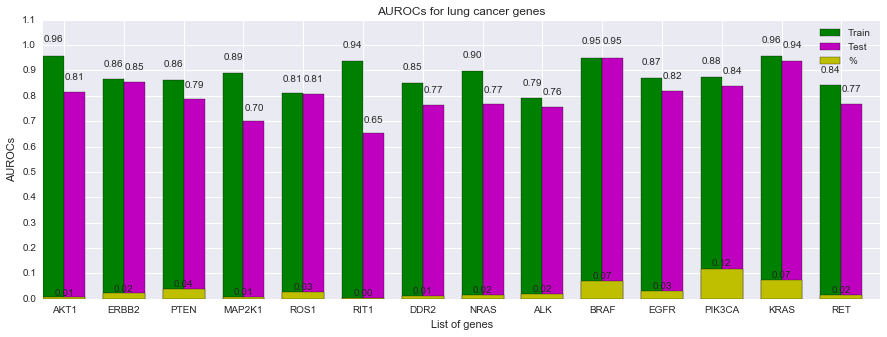

In [10]:
# Plot for lung cancer

ind_lung = np.arange(len(AUROCS_train_lung))  # the x locations for the groups

fig_lung, ax_lung = plt.subplots(figsize=(15, 5))
train_results_lung = ax_lung.bar(ind_lung, AUROCS_train_lung, width, color='g')

test_results_lung = ax_lung.bar(ind_lung + width, AUROCS_test_lung, width, color='m')

per_results_lung = ax_lung.bar(ind_lung, p_lung, 2*width, color='y')

# add some text for labels, title and axes ticks
ax_lung.set_ylabel('AUROCs')
ax_lung.set_title('AUROCs for lung cancer genes')
ax_lung.set_xlabel('List of genes')
ax_lung.set_xticks(ind_lung + width)
ax_lung.set_xticklabels(gene_symbols[0:len(genes_LungCancer)])
ax_lung.set_yticks(np.arange(0, 1.11, 0.1))

ax_lung.legend((train_results_lung[0], test_results_lung[0], per_results_lung[0]), ('Train', 'Test','%'))

autolabel(train_results_lung,ax_lung)
autolabel(test_results_lung,ax_lung)
autolabel(per_results_lung,ax_lung)

plt.show()


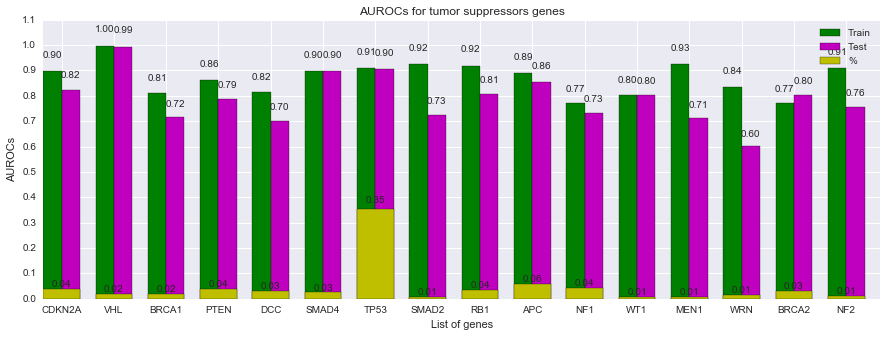

In [11]:
# Plot for tumor suppressors

ind_ts = np.arange(len(AUROCS_train_ts))  # the x locations for the groups

fig_ts, ax_ts = plt.subplots(figsize=(15, 5))
train_results_ts = ax_ts.bar(ind_ts, AUROCS_train_ts, width, color='g')

test_results_ts = ax_ts.bar(ind_ts + width, AUROCS_test_ts, width, color='m')

per_results_ts = ax_ts.bar(ind_ts, p_ts, 2*width, color='y')

# add some text for labels, title and axes ticks
ax_ts.set_ylabel('AUROCs')
ax_ts.set_title('AUROCs for tumor suppressors genes')
ax_ts.set_xlabel('List of genes')
ax_ts.set_xticks(ind_ts + width)
ax_ts.set_xticklabels(gene_symbols[len(genes_LungCancer):len(genes_LungCancer)+len(genes_TumorSuppressors)])
ax_ts.set_yticks(np.arange(0, 1.11, 0.1))

ax_ts.legend((train_results_ts[0], test_results_ts[0], per_results_ts[0]), ('Train', 'Test','%'))

autolabel(train_results_ts,ax_ts)
autolabel(test_results_ts,ax_ts)
autolabel(per_results_ts,ax_ts)


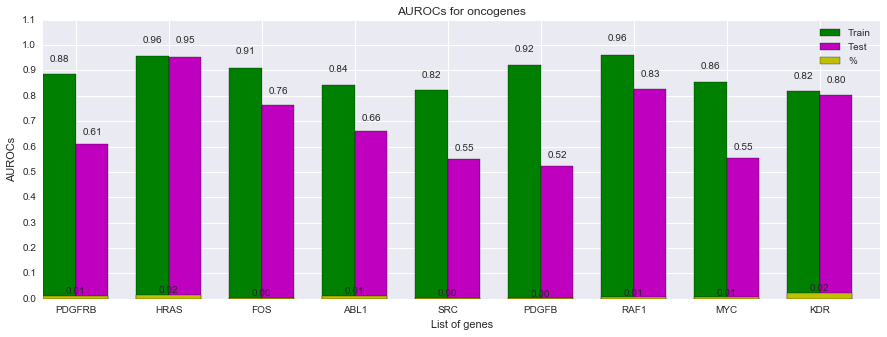

In [12]:
# Plot for oncogenes

ind_on = np.arange(len(AUROCS_train_on))  # the x locations for the groups

fig_on, ax_on = plt.subplots(figsize=(15, 5))
train_results_on = ax_on.bar(ind_on, AUROCS_train_on, width, color='g')

test_results_on = ax_on.bar(ind_on + width, AUROCS_test_on, width, color='m')

per_results_on = ax_on.bar(ind_on, p_on, 2*width, color='y')

# add some text for labels, title and axes ticks
ax_on.set_ylabel('AUROCs')
ax_on.set_title('AUROCs for oncogenes')
ax_on.set_xlabel('List of genes')
ax_on.set_xticks(ind_on + width)
ax_on.set_xticklabels(gene_symbols[len(genes_LungCancer)+len(genes_TumorSuppressors):])
ax_on.set_yticks(np.arange(0, 1.11, 0.1))

ax_on.legend((train_results_on[0], test_results_on[0], per_results_on[0]), ('Train', 'Test','%'))

autolabel(train_results_on,ax_on)
autolabel(test_results_on,ax_on)
autolabel(per_results_on,ax_on)
